<a href="https://colab.research.google.com/github/wilmerod/Curso-de-introduccion-a-Big-Data-Parte-1-nov2021/blob/main/CONVNET_%2B_FINE_TUNNING_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de una Convnet para clasificación de imágenes (Cats and Dogs)

## Cargamos y exploramos los datos
Utilizamos un dataset a partir del que se utilizó en una competición en Kaggle en 2013 (el original contenía 25.000 imágenes), con 2000 imágenes de perros y gatos. Lo extraemos al directorio temporal.

In [ ]:
# Ejecutamos lo siguiente para descargar el dataset. 
# Podremos encontrar los archivos en el directorio correspondiente 
# en la pestaña de Archivos en el menú de la izquierda.

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
# !unzip /tmp/cats_and_dogs_filtered.zip

--2022-07-04 15:14:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.159.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   104MB/s    in 0.6s    

2022-07-04 15:14:25 (104 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Data augmentation
# Para evitar overfitting generaremos nuevas imagenes modificando las
# que tenemos para trabajar
# No haría falta hacer la división (split) de los datos porque 
# ya está hecho en la carpeta que hemos importado con los datos 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creamos el generador de imágenes de entrenamiento
train_gen = ImageDataGenerator(rescale=1/255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               rotation_range=20,
                               horizontal_flip=True,
                               zoom_range=0.1).flow_from_directory('/content/cats_and_dogs_filtered/train')
# Creamos el generador de imágenes de validación/test
valid_gen = ImageDataGenerator(rescale=1/255).flow_from_directory('/content/cats_and_dogs_filtered/validation')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Los índices serán los siguientes
# Para las imágenes de gatos (0) y 
# para las imágenes de perros (1)
train_gen.class_indices

{'cats': 0, 'dogs': 1}

[0. 1.]


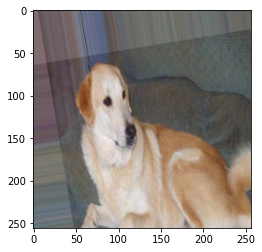

In [ ]:
# Visualizamos las imágenes que se generan
import matplotlib.pyplot as plt

batchX, batchY = next(train_gen)

plt.imshow(batchX[0])
print(batchY[0])

In [ ]:
batchX.shape

(32, 256, 256, 3)

In [ ]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#####---DISEÑO----####

# Creamos al modelo.
model = Sequential()

# Para obtener más información de la dimensión de los datos
model.add(Input(shape=(256, 256, 3)))

# Añadimos capa convolucional con ReLU-activation y strides porque
# MaxPooling2D está en desuso

model.add(Conv2D(filters=32,  kernel_size=5, strides=4, padding="same", activation="relu"))
model.add(Conv2D(filters=64,  kernel_size=5, strides=4, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation="relu"))

# kernel_size: tamaño del filtro 5x5 pixel
# strides: el filtro se mueve cada 4 pixel, es decir, de 4 en 4 pixel
# padding: para no perder la información de los bordes de las imágenes
# ponemos 'same' para que genere un feature map del mismo tamaño 

# Añadimos la parte Fully-connected
# Convertimos en vector la salida
model.add(Flatten())

#Primera capa completamente conectada con ReLU-activation
model.add(Dense(units=100, activation="relu"))

# Capa de salida. Última capa totalmente conectada con activación Softmax
# para usar en la clasificación
model.add(Dense(units=2, activation="softmax"))


In [ ]:
#####---CONFIGURACIÓN----####

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=['acc'])
model.summary()

####---ENTRENAR A LA RED---####
stopping = EarlyStopping(monitor="val_acc", patience=5)

hist = model.fit(train_gen, validation_data=valid_gen, epochs=20, callbacks=[stopping])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         409728    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 2)                 2

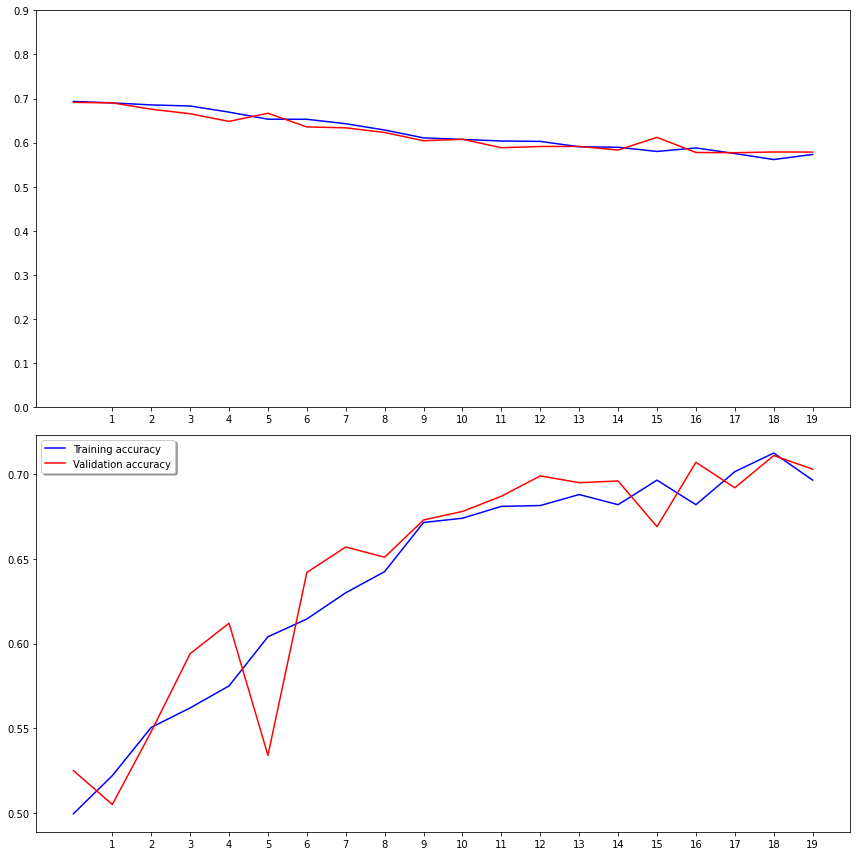

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['acc'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 20, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

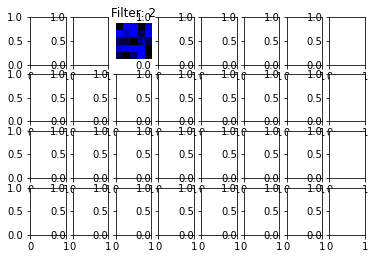

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Visualizamos los filtros 
filters = model.layers[0].weights[0]
fig, axs = plt.subplots(4, 8)

for i in range(filters.shape[3]):
  filt = filters[:,:,:,i]

# Reescalar / Normailzar los filtros
  for i in range(3):
    norF = np.zeros((5,5,3))
    norF[:,:,i] = MinMaxScaler().fit_transform(filt[:,:,i])

  fig.axes[i].imshow(norF)
  fig.axes[i].set_title("Filter: " + str(i))
  fig.axes[i].axis("off")

# No termina de funcionar bien

Trabajando con modelos pre-entrenados: Fine Tuning

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/cats_and_dogs_filtered/train')
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/cats_and_dogs_filtered/validation')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Cargamos un modelo pre-entrenado con Imagenet

vgg_model = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Congelamos al modelo / que los parámetros no se actualicen
for layer in vgg_model.layers[:12]:
  layer.trainable = False

# Construimos al modelo
model = Sequential()

model.add(vgg_model)

model.add(Flatten())
model.add(Dense(units=100, activation="relu"))
model.add(Dense(units=2,   activation="softmax"))


80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
# Configuración
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["acc"])

# Entrenamos al modelo
model.fit(train_gen, validation_data=valid_gen, epochs=10)


Epoch 1/10
63/63 [==============================] - 38s 511ms/step - loss: 1.0428 - acc: 0.8505 - val_loss: 0.2991 - val_acc: 0.9370
Epoch 2/10
63/63 [==============================] - 30s 472ms/step - loss: 0.0261 - acc: 0.9935 - val_loss: 0.2396 - val_acc: 0.9500
Epoch 3/10
63/63 [==============================] - 29s 462ms/step - loss: 8.7102e-04 - acc: 1.0000 - val_loss: 0.2354 - val_acc: 0.9510
Epoch 4/10
63/63 [==============================] - 29s 459ms/step - loss: 4.1007e-04 - acc: 1.0000 - val_loss: 0.2332 - val_acc: 0.9510
Epoch 5/10
63/63 [==============================] - 29s 464ms/step - loss: 2.9964e-04 - acc: 1.0000 - val_loss: 0.2316 - val_acc: 0.9520
Epoch 6/10
63/63 [==============================] - 29s 462ms/step - loss: 2.3641e-04 - acc: 1.0000 - val_loss: 0.2304 - val_acc: 0.9530
Epoch 7/10
63/63 [==============================] - 29s 460ms/step - loss: 1.9493e-04 - acc: 1.0000 - val_loss: 0.2296 - val_acc: 0.9530
Epoch 8/10
63/63 [==============================]

In [ ]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Probamos con una imagen de mis mascotas

from tensorflow.keras.preprocessing.image import load_img, img_to_array

img = img_to_array(load_img('/content/IMG_20210815_101137.jpg', target_size=(256,256)))
img = preprocess_input(img)


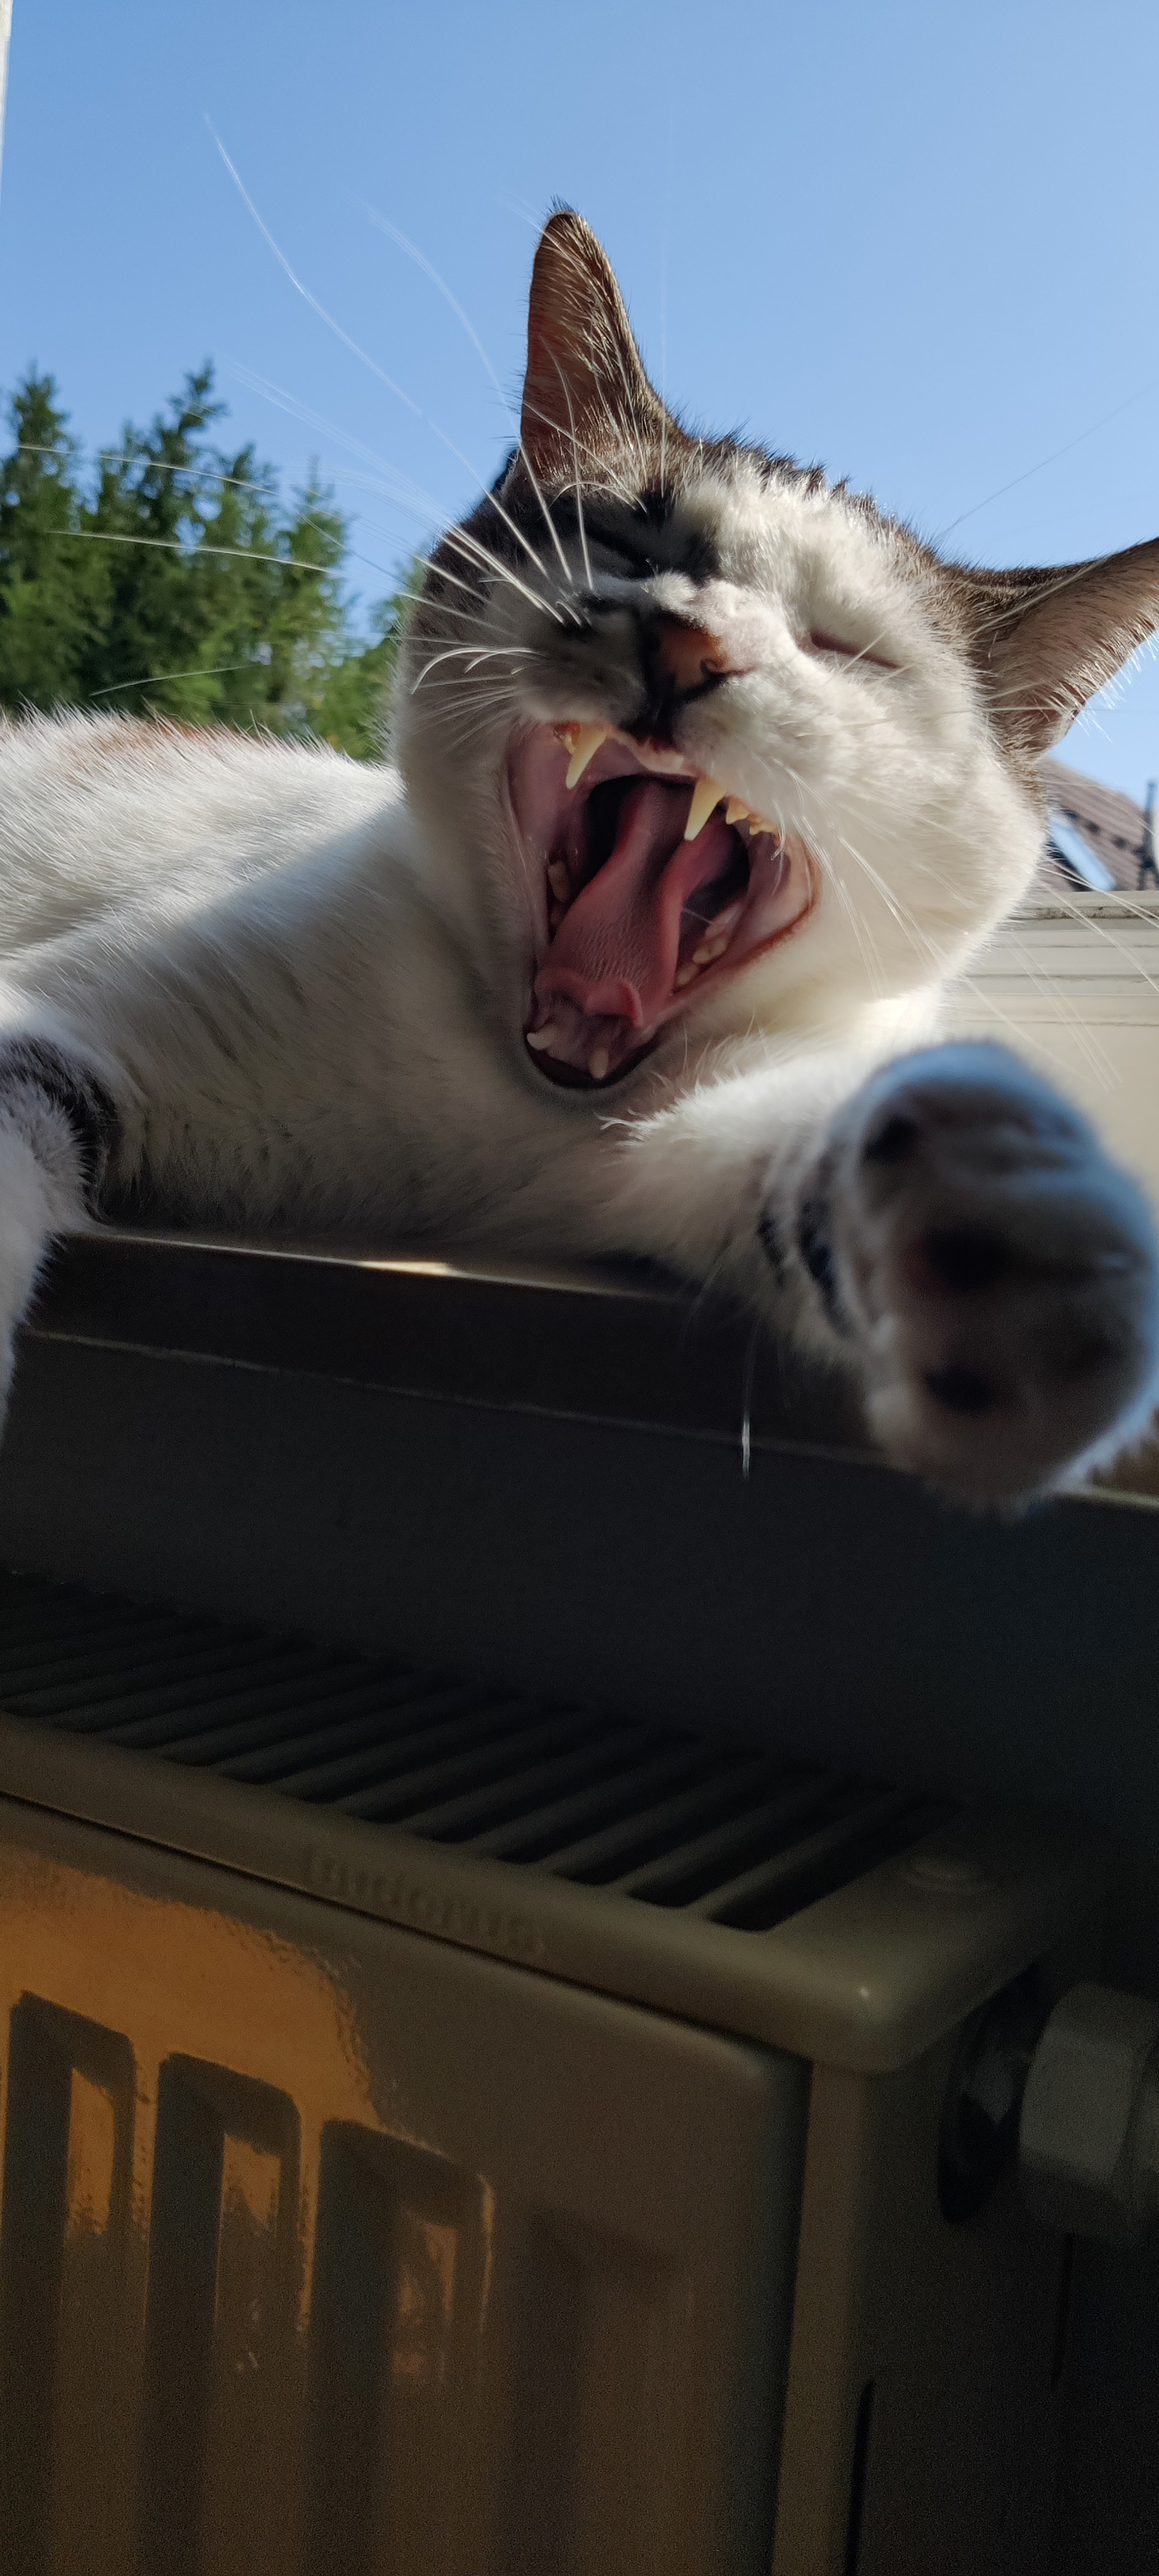

In [ ]:
load_img('/content/IMG_20210815_101137.jpg')

In [ ]:
model.predict(img.reshape(1,256,256,3))
# Resultado [1,0]: Gato
# Resultado [0,1]: Perro

array([[1.0000000e+00, 1.1888844e-08]], dtype=float32)

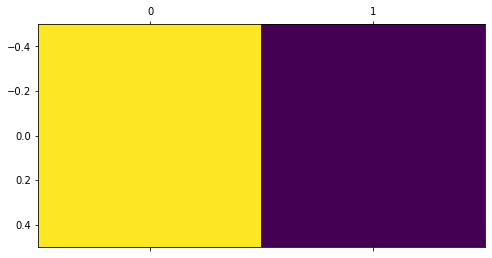

In [ ]:
plt.matshow(model.predict(img.reshape(1, 256, 256, 3)))